## Tokamesh - geometry matrix calculation demo
This notebook demonstrates how to calculate a geometry matrix using tools from the `tokamesh.geometry` module.

First, we need to set-up a test case. Start by building a simple mesh:

In [1]:
# create an equilateral mesh covering the specified area
from tokamesh.construction import equilateral_mesh
R, z, triangles = equilateral_mesh(
    R_range=(0.3, 1.5),
    z_range=(-0.5, 0.5),
    resolution=0.02
)

Now define an example emission function which specifies an emission at each vertex:

In [2]:
from numpy import sqrt, exp
def emission_func(R, z):
    w = 0.05
    r = sqrt((R - 0.8)**2 + (z + 0.1)**2)
    return exp(-0.5 * (r / w)**4) + 0.5 * exp(-0.5 * ((r - 0.3) / w)**2)

# evaluate the emission at each vertex of the mesh
emission = emission_func(R, z)

Use the `plot_field` method of the `TriangularMesh` class to efficiently generate a filled colour contour plot of the 2D field:

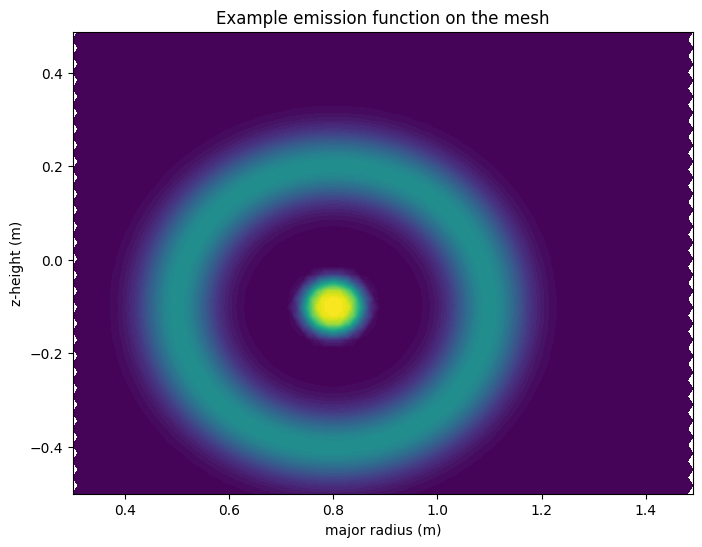

In [3]:
from tokamesh import TriangularMesh
mesh = TriangularMesh(R, z, triangles)

# plot the emission
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
mesh.plot_field(ax=ax, vertex_values=emission)
ax.set_title('Example emission function on the mesh')
ax.set_xlabel('major radius (m)')
ax.set_ylabel('z-height (m)')
plt.show()

Now we use the `Camera` class to generate lines of sight which will image the emission distribution

In [4]:
from numpy import array
from tokamesh.utilities import Camera
pixels = 150
cam = Camera(
    position=array([1.6, 1.8, 1.25]),
    direction=array([-1.0, -0.7, -0.8]),
    fov=40.0,
    max_distance=4.0,
    num_x=pixels,
    num_y=pixels
)

Now the test-case is set-up, we can calculate the geometry matrix using the `calculate_geometry_matrix`:

In [5]:
from tokamesh.geometry import calculate_geometry_matrix
geomat = calculate_geometry_matrix(
    R=R,
    z=z,
    triangles=triangles,
    ray_origins=cam.ray_starts,
    ray_ends=cam.ray_ends,
    n_processes=4
)

 >> Calculating geometry matrix:  [ completed in 0:00:09 ]                 


`calculate_geometry_matrix` returns an instance of the `GeometryMatrix` class which packages the geometry matrix data. We can use the `build_sparse_array` method to build a sparse array representation of the matrix:

In [6]:
G = geomat.build_sparse_array()

Taking the matrix-vector product of the geometry matrix and the emission values at each vertex yields a vector of the brightness of each camera pixel:

In [7]:
pixel_brightness = G @ emission
# re-shape the pixel brightness into an image
brightness_image = pixel_brightness.reshape([pixels, pixels])

Now plot the geometry matrix prediction of the camera image of the emission distribution

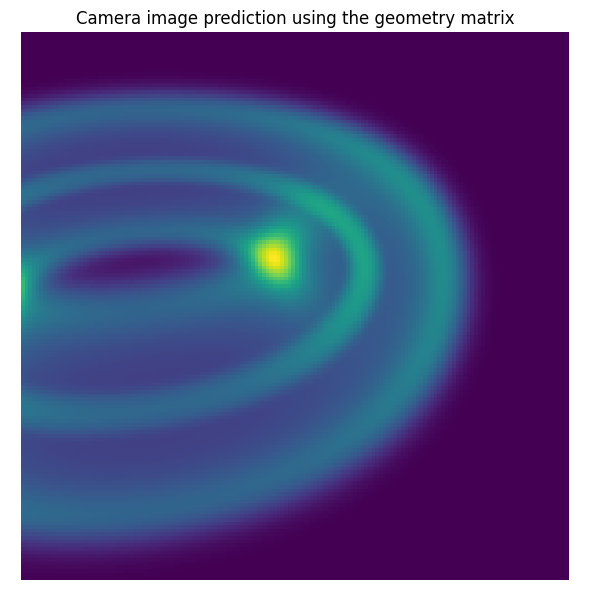

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(brightness_image.T)
ax.axis('equal')
ax.set_title('Camera image prediction using the geometry matrix')
ax.axis('off')
plt.tight_layout()
plt.show()